# Sentinel-1 flood mapping on Myanmar 2019 data
## using Jupyter Notebook, SNAP and snapista 

In [1]:
import os
import sys
import time
from subprocess import Popen, PIPE, STDOUT
import glob
import shutil
from datetime import datetime
import numpy, matplotlib
!pip install rasterio
import rasterio
from rasterio.plot import show

# snapista imports
from snapista import Graph
from snapista import Operator, OperatorParams

import sys
import os

     |████████████████████████████████| 19.2 MB 4.3 MB/s eta 0:00:013 MB/s eta 0:00:01


# Satellite data and Area of interest Bounding Box definition 

In [2]:
# Copernicus Sentinel-1 data for the demo is found under the data folder
reference_image='/home/jovyan/data/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED.zip'
flood_image='/home/jovyan/data/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF.zip'

# Bounding Box definition for subsetting the satellite images
lonmin=95.91321563720703
latmin=23.406635284423828
lonmax=96.40089416503906
latmax=23.948501586914062
polygon='POLYGON ((95.91321563720703 23.948501586914062, 96.40089416503906 23.948501586914062, 96.40089416503906 23.406635284423828, 95.91321563720703 23.406635284423828, 95.91321563720703 23.948501586914062, 95.91321563720703 23.948501586914062))'

# Using SNAPISTA for the S1 data pre-processing

### Graph definition using SNAPISTA


In [5]:
# Graph definition using SNAPISTA
def S1_preprocessing(myfile,wktaoi):
    outputfile=os.path.join('/home/jovyan/work',os.path.basename(myfile)[:-4]+'_Orb_Cal_BrdRmv_dB_Sub_TC.tif')
    g = Graph()
    #Read
    g.add_node(
        operator=Operator(
            "Read",
            formatName="SENTINEL-1",
            file=myfile,
        ),
        node_id="read",
    )
    # Calibration
    g.add_node(
        operator=Operator("Calibration",
            selectedPolarisations='VV',
            ),
        node_id="calibration",
        source='read',
    )
    # Linear to dB conversion
    g.add_node(
        operator=Operator("LinearToFromdB"),
        node_id="dBconversion",
    source="calibration",
    )
    # Subset
    g.add_node(
        operator=Operator('Subset', geoRegion=wktaoi),
        node_id='subset',
        source='dBconversion',
    )
    # Terrain Correction / Geocoding
    g.add_node(
        operator=Operator("Terrain-Correction",
            pixelSpacingInMeter="20.0",
            demName="SRTM 1Sec HGT",
        ),
        node_id="terrain-correction",
        source="subset",
    )
    # Write to GeoTIFF-BigTIFF
    g.add_node(
        operator=Operator("Write", file=outputfile, formatName="GeoTIFF"),
        node_id="write",
        source="terrain-correction",
    )

    ##############################
    ## Executing graph
    ##############################
    print(g)
    #Uncomment the line below to save the graph to disc
    #g.save_graph('mygraph.xml')
    g.run()

# Preprocess of Sentinel-1 data

In [6]:
# Preprocess of Sentinel-1 data
files=[reference_image,flood_image]
for myfile in files:
    print('###########################################################################')
    print('Preprocessing file :'+myfile)
    S1_preprocessing(myfile,polygon)

###########################################################################
Preprocessing file :/home/jovyan/data/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED.zip
gpt binary: /opt/conda/snap/bin/gpt
working dir: .

<graph>
  <version>1.0</version>
  <node id="read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <bandNames/>
      <copyMetadata>true</copyMetadata>
      <file>/home/jovyan/data/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED.zip</file>
      <formatName>SENTINEL-1</formatName>
      <geometryRegion/>
      <maskNames/>
      <pixelRegion/>
    </parameters>
  </node>
  <node id="calibration">
    <operator>Calibration</operator>
    <sources>
      <sourceProduct refid="read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <auxFile>Latest Auxiliary File</auxFile>
      <createBetaBand>false</createBetaBand>
      <createGa

## Visualising pre-processed pre-event Sentinel-1 data

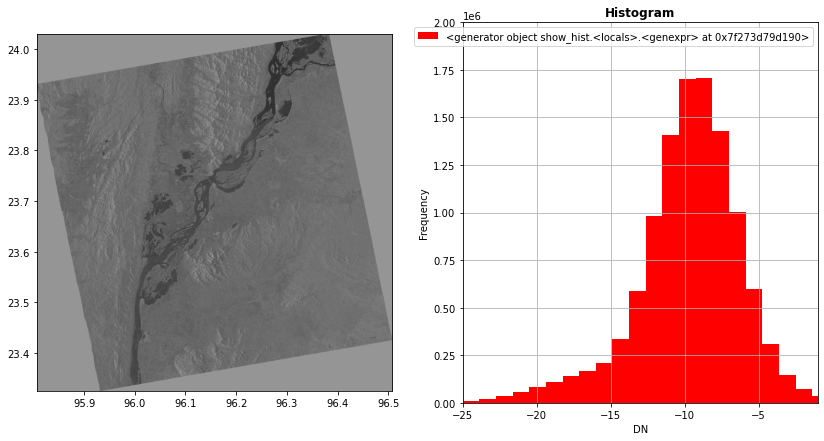

In [2]:
#!pip install rasterio
import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy as np
import glob
import os

reference_image='/home/jovyan/data/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED.zip'
flood_image='/home/jovyan/data/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF.zip'
workdir='/home/jovyan/work'
reference=glob.glob(workdir+'/'+os.path.basename(reference_image[:-4])+'*.tif')[0]

with rasterio.open(reference) as src:
    band=src.read(1)
    #show_hist(band, bins=100, masked=True, title='Histogram', ax=None, label=None)
    #show(band,cmap='gray')
    fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb,cmap='gray')
    show_hist(src, bins=50, histtype='stepfilled',lw=0.0, stacked=False, ax=axhist)
    axhist.set(xlim=(-25, -1), ylim=(0, 2e6))
    pyplot.show()

## Visualising pre-processed post-event Sentinel-1 data (flood image)

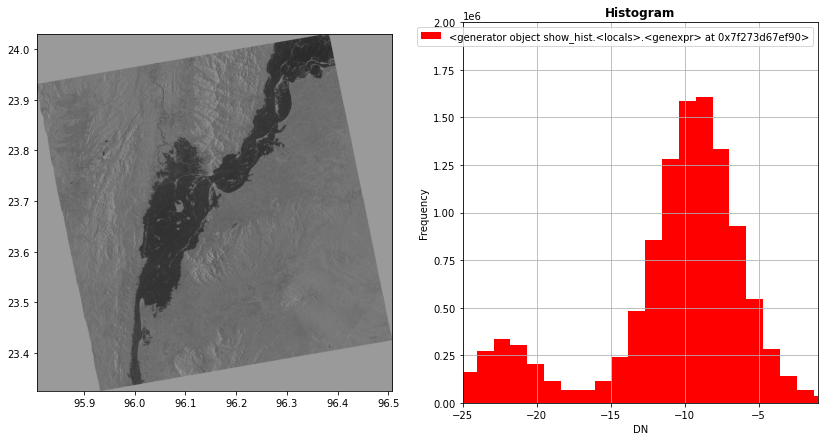

In [3]:
#!pip install rasterio
import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy as np
import glob
import os

workdir='/home/jovyan/work'
flooded=glob.glob(workdir+'/'+os.path.basename(flood_image[:-4])+'*.tif')[0]

with rasterio.open(flooded) as src:
    band=src.read(1)
    fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb,cmap='gray')
    show_hist(src, bins=50, histtype='stepfilled',lw=0.0, stacked=False, ax=axhist)
    axhist.set(xlim=(-25, -1), ylim=(0, 2e6))
    pyplot.show()

# Flood detection using the SNAP Math band


## Computing flood mask using user defined thresholds


In [4]:
from snapista import Graph
from snapista import Operator
from snapista import TargetBand
from snapista import TargetBandDescriptors

In [5]:
stack=Operator('CreateStack')

# Stacking pre-processed Sentinel-1 data

### function definition

In [6]:
def stacking(myfile1,myfile2):
    outputfile=os.path.join(os.path.dirname(myfile1),'stack_images.tif')

    g = Graph()
    #ProductSet-Reader
    g.add_node(
        operator=Operator(
            "ProductSet-Reader",
            fileList=myfile1+','+myfile2
        ),
        node_id="read",
    )
    # Stack
    g.add_node(
        operator=Operator(
            "CreateStack", 
            resamplingType='NEAREST_NEIGHBOUR',
            extent='Master',
            initialOffsetMethod='Product Geolocation'
        ),
        node_id="stack",
        source="read",
    )
    # Write to GeoTIFF-BigTIFF
    g.add_node(
        operator=Operator("Write", file=outputfile, formatName="GeoTIFF-BigTIFF"),
        node_id="write",
        source='stack',
    )

    ##############################
    ## Executing graph
    ##############################
    print(g)
    #Uncomment the line below to save the graph to disc
    #g.save_graph('mystack.xml')
    g.run()

### Stacking the data

In [7]:
import glob
import os
reference_prec=glob.glob(os.path.join(workdir,'*20190704*tif'))[0]
flood_prec=glob.glob(os.path.join(workdir,'*20190716*tif'))[0]

print(reference_prec)
print(flood_prec)
stacking(reference_prec,flood_prec)

/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_BrdRmv_dB_Sub_TC.tif
/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_BrdRmv_dB_Sub_TC.tif
gpt binary: /opt/conda/snap/bin/gpt
working dir: .

<graph>
  <version>1.0</version>
  <node id="read">
    <operator>ProductSet-Reader</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <fileList>/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_BrdRmv_dB_Sub_TC.tif,/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_BrdRmv_dB_Sub_TC.tif</fileList>
    </parameters>
  </node>
  <node id="stack">
    <operator>CreateStack</operator>
    <sources>
      <sourceProduct refid="read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <extent>Master</extent>
      <initialOffsetMethod>Product Geolocat

### flood map function definition

In [8]:
import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy as np
import glob
import os

def floodmap_generation(stack,thr1,thr2):
    # Initialising flood matrix
    flood=[]
    with rasterio.open(stack) as src:
        band1=src.read(1)
        band2=src.read(2)
        fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
        show(src, ax=axrgb,cmap='gray')
        show_hist(src, bins=50, histtype='stepfilled',lw=0.0, stacked=False, ax=axhist)
        axhist.set(xlim=(-25, -1), ylim=(0, 2e6))
        pyplot.show()
        flood=np.where(((band1 > thr1) & (band2 < thr2)),1,0)
        height, width = band1.shape
        transform=src.transform
        crs=src.crs
        profile=src.profile
        meta=src.meta
        #
    with rasterio.open(os.path.join(workdir,'flood_mask.tif'),'w',driver='GTiff',nodata=0.0,height=height,width=width,
                       count=1,dtype='uint8',
                       crs=crs,transform=transform) as dst: 
        dst.write(flood,1)
        pyplot.imshow(flood, cmap='gray')
        pyplot.show()

## generating flood map
### Water values considered for calibratted sigma0_VV :
### - for dry image: -14 dB
### - for flood image: -15 dB 

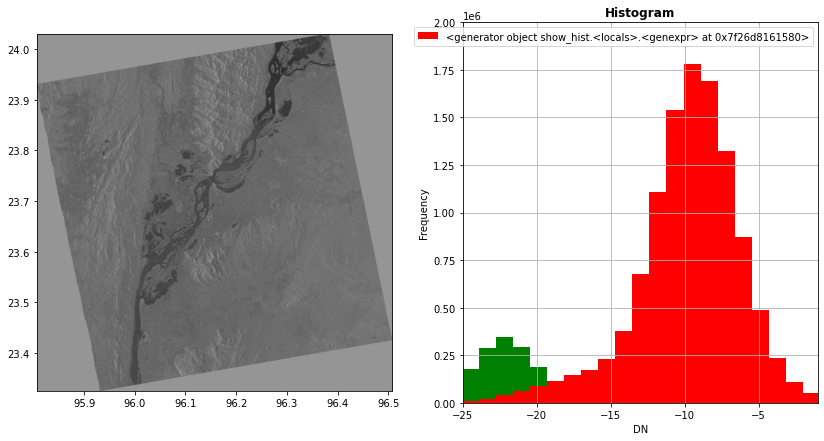

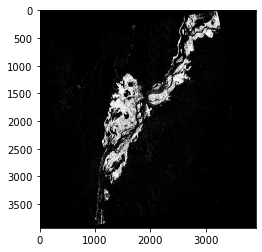

In [9]:
###################################################
# Stack image location definition
stack=os.path.join(workdir,'stack_images.tif')

####################################################
# Thresholds for dry and flood image definition
thrdry=-14
thrflood=-15
#####################################################
# Executing function
floodmap_generation(stack,thrdry,thrflood)

# Create quicklook visualisation of results
### function definition of quicklook generation

In [25]:
# function definition of quicklook generation
from datetime import datetime
import time
import glob
from subprocess import Popen,PIPE,STDOUT

def quicklook_gen(image): #,colormap):
    now = datetime.now()
    tmpfolder='/home/jovyan/work'
    if 'mask' in image:
        cmd=['/opt/conda/snap/bin/pconvert','-b','1','-c','/home/jovyan/resources/mycolor.cpd',image,'-f','png','-o',tmpfolder]
    else:
        cmd=['/opt/conda/snap/bin/pconvert','-b','1',image,'-f','png','-o',tmpfolder]
    print('#########################')
    print('Creating browse image')
    timeStarted = time.time()
    process = Popen(cmd, stdout=PIPE, stderr=STDOUT)
    r = b""
    for line in process.stdout:
        r += line
        print(str(line))
    process.wait()
    timeDelta = time.time() - timeStarted                     # Get execution time.
    print('Finished process in '+str(timeDelta)+' seconds.')
    if process.returncode != 0 :
        message='Error creating browse image'
    else:
        message='Browse image successfully completed.'
        print( message)


In [26]:
# Creating quicklook for results
mask=glob.glob('/home/jovyan/work/flood_mask.tif')[0]
reference=glob.glob('/home/jovyan/work/'+os.path.basename(reference_image)[:-4]+'*.tif')[0]
flooded=glob.glob('/home/jovyan/work/'+os.path.basename(flood_image)[:-4]+'*.tif')[0]
images=[reference,flooded,mask]
print(images)
for file in images:
    print('Generating quicklook of file:'+file)
    quicklook_gen(file)#,None)

['/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_BrdRmv_dB_Sub_TC.tif', '/home/jovyan/work/S1A_IW_GRDH_1SDV_20190716T113944_20190716T114009_028142_032DBA_8FFF_Orb_Cal_BrdRmv_dB_Sub_TC.tif', '/home/jovyan/work/flood_mask.tif']
Generating quicklook of file:/home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T113943_20190704T114008_027967_03286B_1EED_Orb_Cal_BrdRmv_dB_Sub_TC.tif
#########################
Creating browse image
b'INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters\n'
b'INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.1.4 found on system. Internal GDAL 3.0.0 from distribution will be used.\n'
b'INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.\n'
b'INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.\n'
b'reading file /home/jovyan/work/S1A_IW_GRDH_1SDV_20190704T1

# Results visualisation
### For results visualisation you may consider to use the provided Notebook called Results_visualisation.ipynb found in the resources folder